# Recipe classification `14 points`

Source: `recipes.csv`, which I scraped from... somewhere. Each row represents a recipe.

**Topics**

* Filtering
* Text analysis
* Classification

In [1]:
import pandas as pd

df = pd.read_csv('recipes.csv')

## Filtering and aggregating `3 points`

### What is the most common cuisine in this dataset?

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cuisine          39774 non-null  object
 1   id               39774 non-null  int64 
 2   ingredient_list  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [4]:
# Italian
df.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

### Plot a bar graph of cuisine popularity, with the most common at the top

<AxesSubplot:>

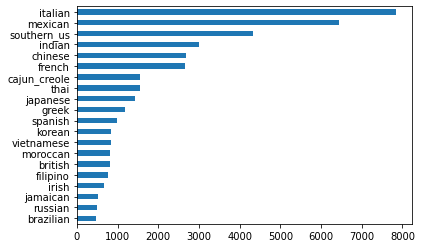

In [12]:
df.cuisine.value_counts(ascending=True).plot(kind='barh')

### Clean up the names so we get nicer graphics

"southern_us" should be "Southern US," "russian" should be "Russian," etc.

In [17]:
df.cuisine.unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [18]:
old_names = ['greek', 'southern_us', 'filipino', 'indian', 'jamaican','spanish', 'italian', 'mexican', 'chinese', 'british', 
'thai','vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese','irish', 'korean', 'moroccan', 'russian']

In [19]:
new_names = ['Greek', 'Southern US', 'Filipino', 'Indian', 'Jamaican','Spanish', 'Italian', 'Mexican', 'Chinese', 'British', 
'Thai','Vietnamese', 'Cajun Creole', 'Brazilian', 'French', 'Japanese','Irish', 'Korean', 'Moroccan', 'Russian']

In [21]:
name_replace = dict(zip(old_names, new_names))

name_replace

{'greek': 'Greek',
 'southern_us': 'Southern US',
 'filipino': 'Filipino',
 'indian': 'Indian',
 'jamaican': 'Jamaican',
 'spanish': 'Spanish',
 'italian': 'Italian',
 'mexican': 'Mexican',
 'chinese': 'Chinese',
 'british': 'British',
 'thai': 'Thai',
 'vietnamese': 'Vietnamese',
 'cajun_creole': 'Cajun Creole',
 'brazilian': 'Brazilian',
 'french': 'French',
 'japanese': 'Japanese',
 'irish': 'Irish',
 'korean': 'Korean',
 'moroccan': 'Moroccan',
 'russian': 'Russian'}

<AxesSubplot:>

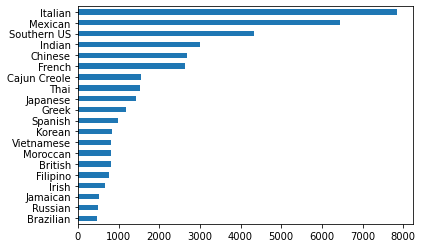

In [26]:
df.cuisine = df.cuisine.replace(name_replace)

df.cuisine.value_counts(ascending=True).plot(kind='barh')

## Text analysis

### Build a classifier to predict whether a recipe is Greek or not `2 points`

### Using a confusion matrix, show how well it classifies Greek recipes `1 point`

It won't be perfect, but it shouldn't be *completely awful*.

### List the top 20 ingredients that predict a recipe to be greek or a recipe to be not greek `2 points`

## Create, evaluate, and examine the weights of a Mexican food classifier `3 points`

## Multi-class classification `3 points`

### Encode the recipe names as numbers

Let's convert each label - greek, southern US, indian, etc - to be a number. You can have this code:

```py
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['cuisine_label'] = le.fit_transform(df.cuisine)
df.head()
```

### Build a classifier to predict this new `cuisine_label` column

### Using a confusion matrix, see what cuisines it confuses

Here's the multi-class version:

```py
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(le.classes_)
scores = pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1), axis=0)
scores.style.background_gradient(cmap='YlGnBu')
```

### What cuisine is it most likely to confuse a Vietnamese recipe with?

### What cuisine is it the worst at classifying?